# Calculate Cell Doublet Score

## Content
Here we assign a doublet score to each cell. The MethylScrblet method we used here is adapted from the [Scrublet package](https://github.com/AllonKleinLab/scrublet) (REF). High doublet score indicates the cell is likely merged from different cell types.

## Prerequisite
Before this step, run the [Basic Clustering Walk-through](../basic/mch_mcg_100k_basic.ipynb) to get the cell-by-feature AnnData file.


## Input
- MCDS Files (contains chrom100K dim)
- Cell Metadata
- Output AnnData file from [Basic Clustering Walk-through](../basic/mch_mcg_100k_basic.ipynb).

## Output
- Cell doublet score



## Import

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from ALLCools.clustering import MethylScrublet
from ALLCools.plot import *
from ALLCools import MCDS

## Parameters

In [5]:
# change this to the paths to your MCDS files
mcds_path_list = [
    '../../data/MOp/3C-171206.mcds',
]

adata_path = '../basic/MOp.chrom100k-clustering.h5ad'
var_name = 'chrom100k'

load = True
mc_type = 'CHN'

# use feature type
# HVF: all highly variable features
# CEF: cluster enriched features
feature_type = 'CEF'

# Clustering resolution
resolution = 0.3
n_neighbors = 10
expected_doublet_rate=0.08

plot_type = 'static'

## Load

### AnnData with clustering results

In [6]:
adata = anndata.read_h5ad(adata_path)
hvf = adata.var_names.astype(int)
hvf.name = var_name

In [20]:
import scanpy as sc

In [28]:
sc.tl.leiden(adata, resolution=0.3)

### Raw mC counts

In [29]:
mcds = MCDS.open(mcds_path_list, obs_dim='cell', use_obs=adata.obs_names)

In [30]:
mc = mcds['chrom100k_da'].sel({
    'mc_type': mc_type,
    'count_type': 'mc',
    hvf.name: hvf
})
cov = mcds['chrom100k_da'].sel({
    'mc_type': mc_type,
    'count_type': 'cov',
    hvf.name: hvf
})

if load and (mcds.get_index('cell').size <= 20000):
    mc.load()
    cov.load()

## Calculate Doublet Scores

Calculating mC frac of observations...
Simulating doublets...
Cell cluster labels are given, will sample similar number of cells from each cluster.
PCA...
Calculating doublet scores...
Automatically set threshold to 0.01
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 83.9%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 7.0%


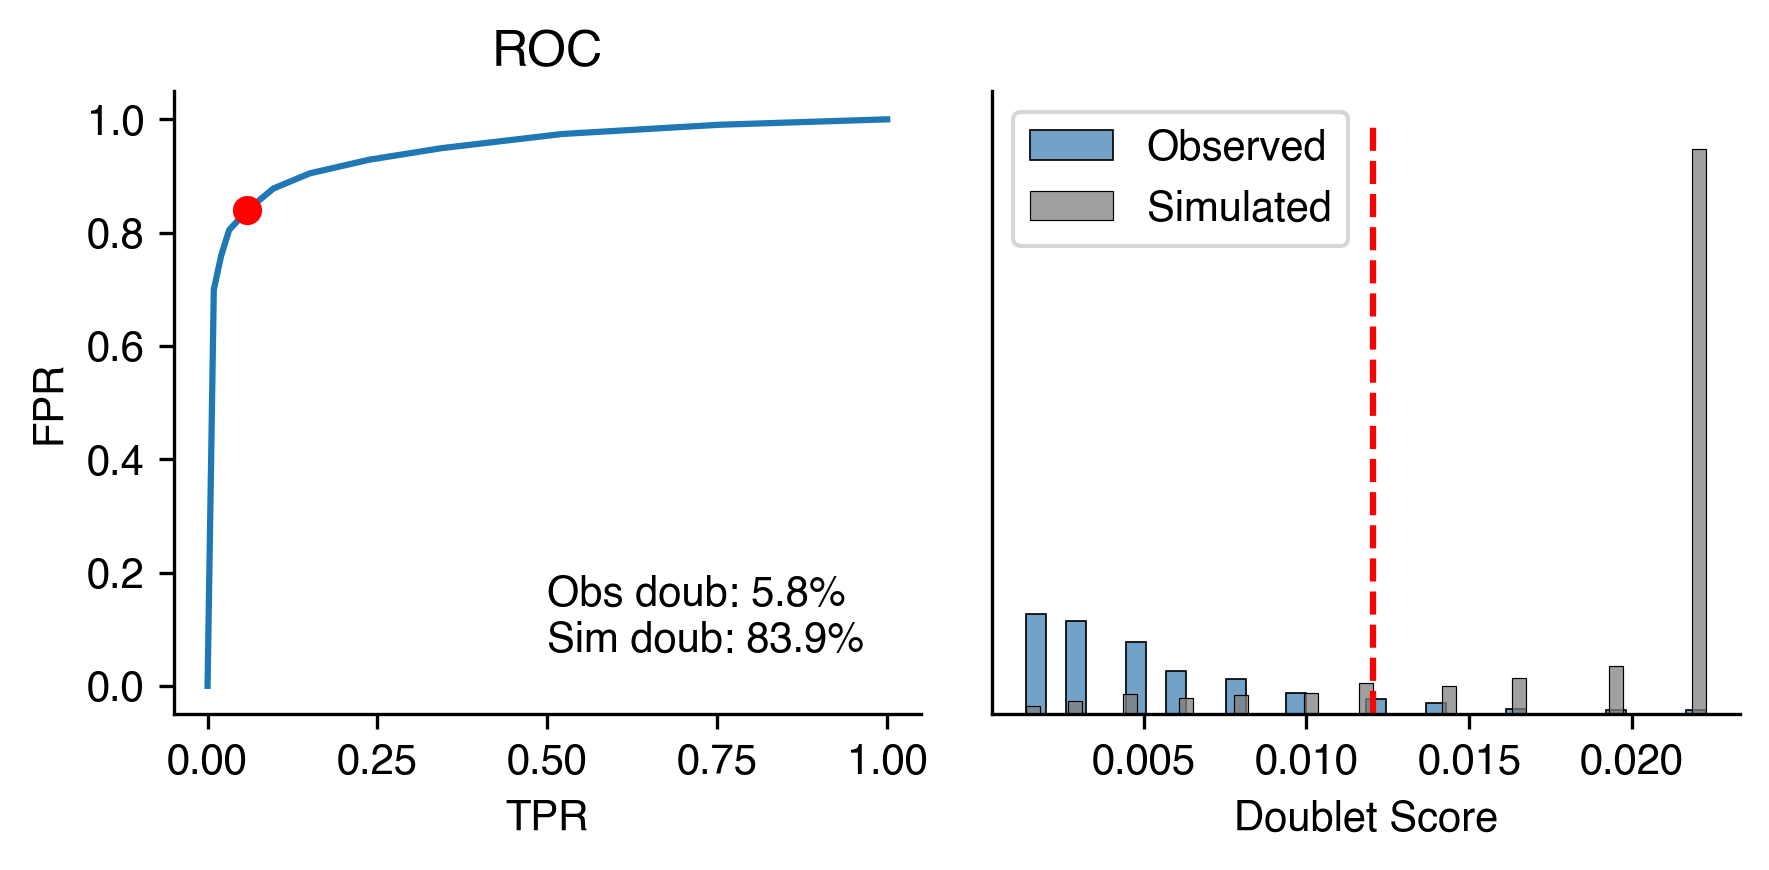

In [34]:
scrublet = MethylScrublet(sim_doublet_ratio=2.0,
                          n_neighbors=n_neighbors,
                          expected_doublet_rate=expected_doublet_rate,
                          stdev_doublet_rate=0.02,
                          metric='euclidean',
                          random_state=0,
                          n_jobs=-1)
score, judge = scrublet.fit(mc, cov, clusters=adata.obs[cluster_col_name])
adata.obs['doublet_score'] = score
adata.obs['is_doublet'] = judge
scrublet.plot()

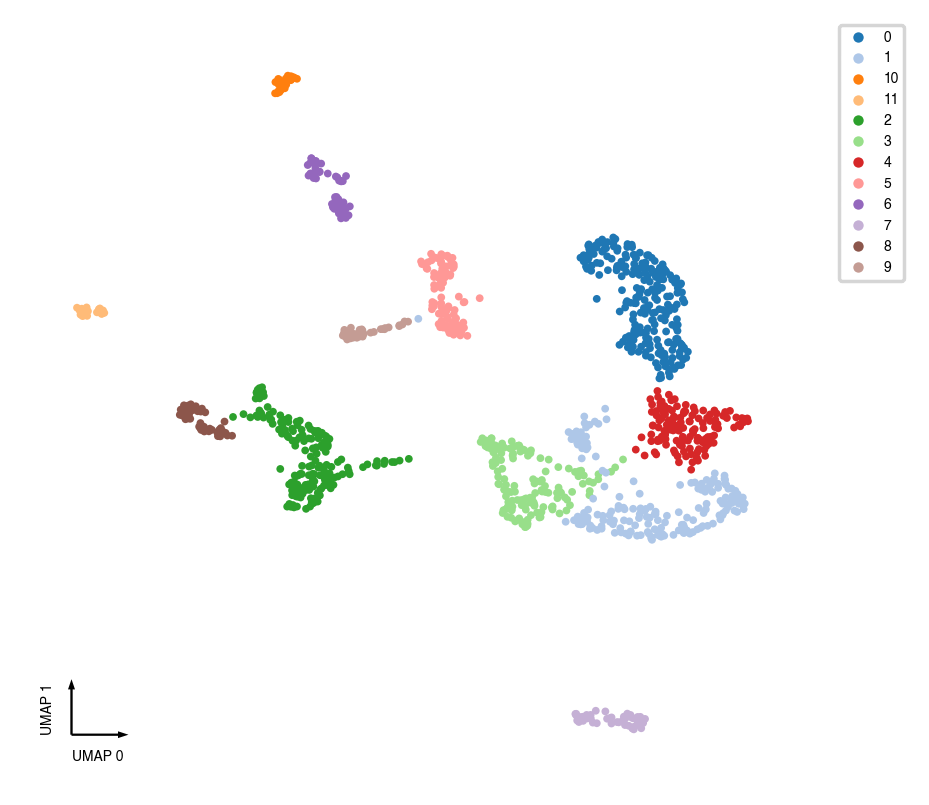

In [35]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs, ax=ax, coord_base='umap', hue=cluster_col_name, show_legend=True)

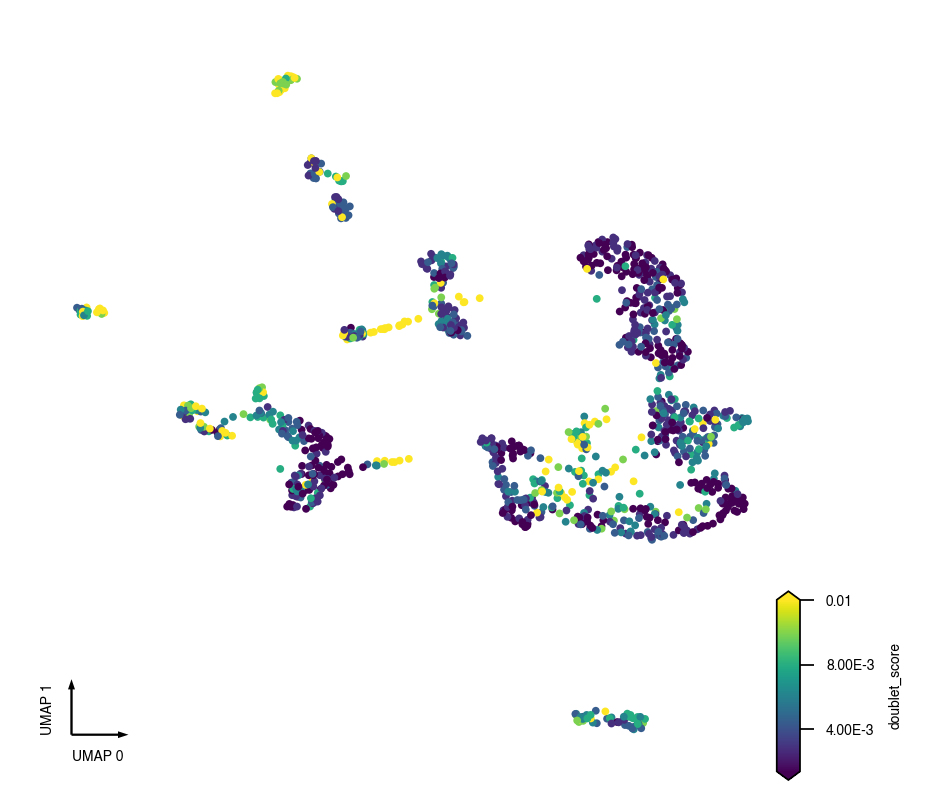

In [36]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata.obs, ax=ax, coord_base='umap', hue='doublet_score')

## Plots

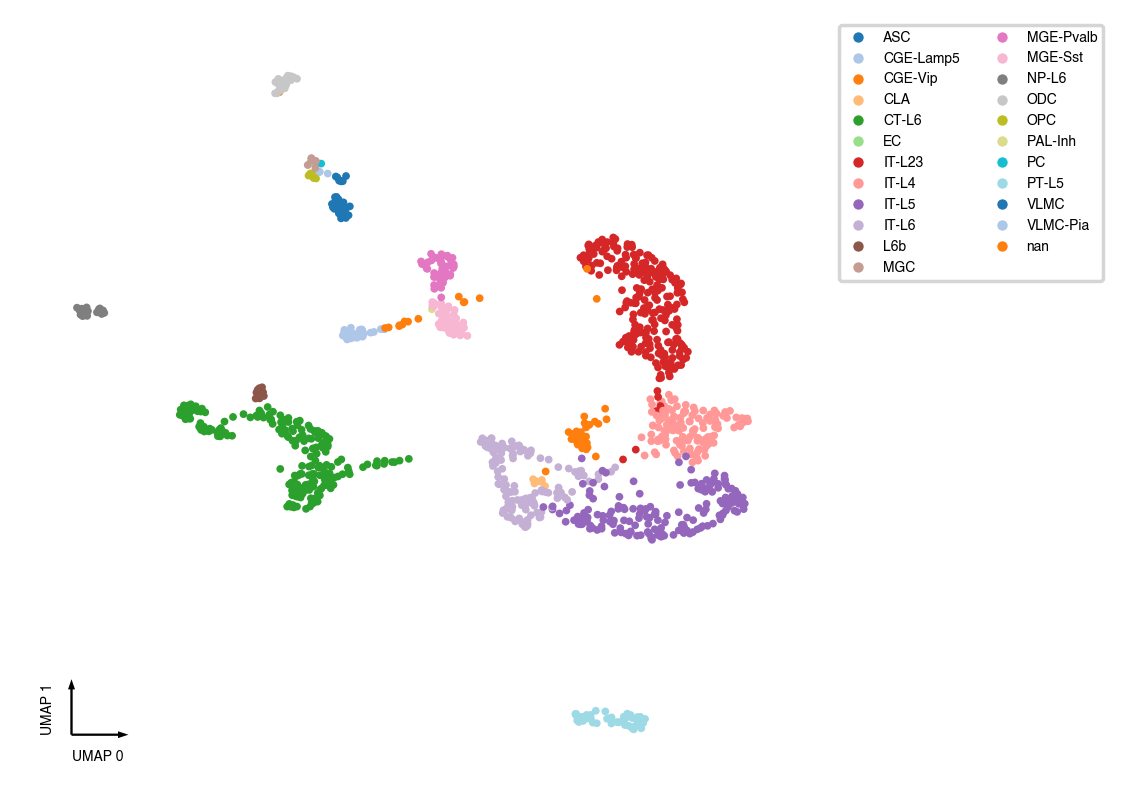

In [43]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='CellTypeAnno',
                        palette='tab20',
                        show_legend=True)

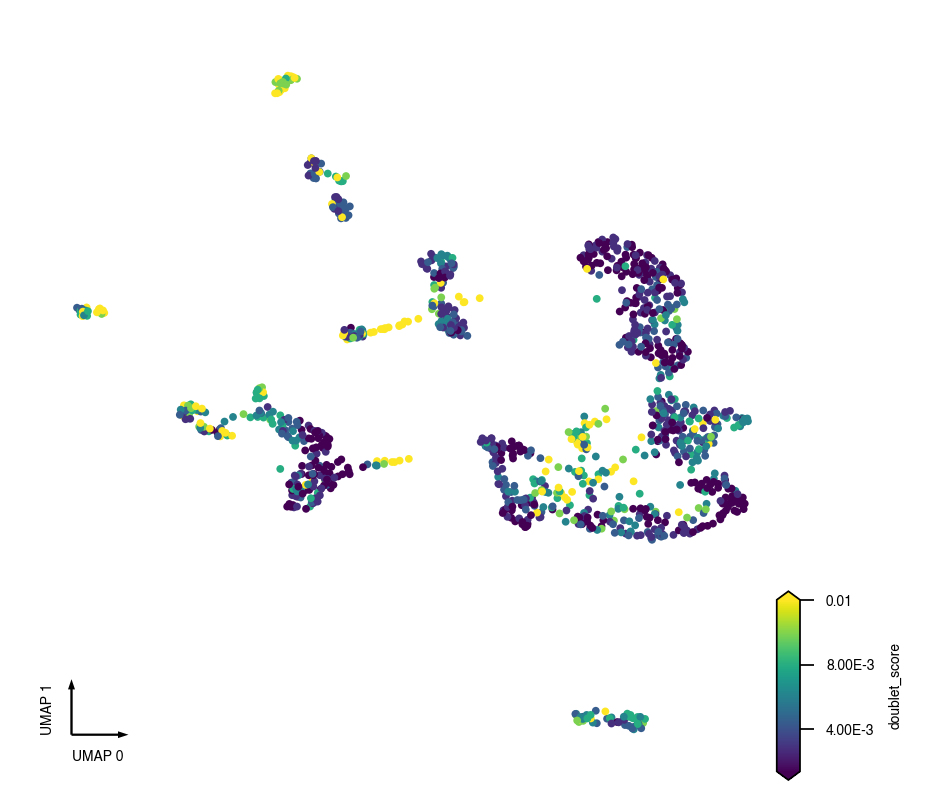

In [38]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata.obs, ax=ax, coord_base='umap', hue='doublet_score')

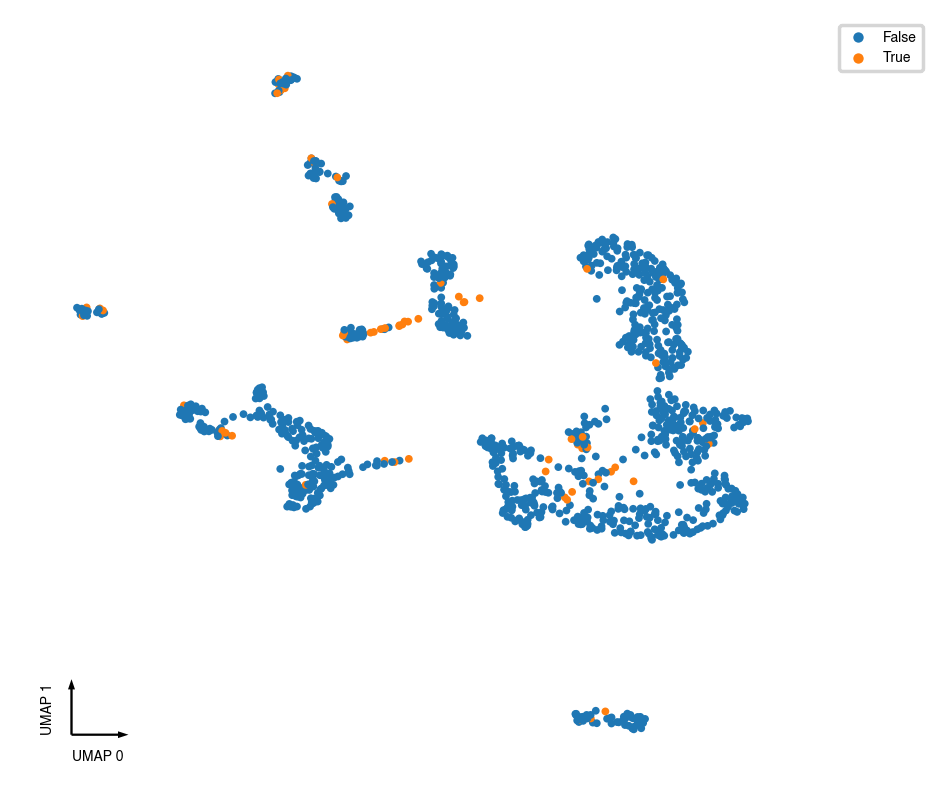

In [39]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs, ax=ax, coord_base='umap', hue='is_doublet', show_legend=True)